# Clustering *P. aeruginosa* data

This notebook will plot the clustering of P. aeruginosa data by strain type to demonstrate that clustering is perserved in VAE latent space.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import umap
import glob
import os
from keras.models import load_model
from sklearn.decomposition import PCA
from plotnine import (
    ggplot,
    labs,
    geom_line,
    geom_point,
    geom_errorbar,
    aes,
    ggsave,
    theme_bw,
    theme,
    xlim,
    ylim,
    facet_wrap,
    scale_color_manual,
    guides,
    guide_legend,
    element_blank,
    element_text,
    element_rect,
    element_line,
    coords,
)

from numpy.random import seed

random_state = 1
seed(random_state)

Using TensorFlow backend.


In [2]:
# Pa expression data
raw_pa_compendium_filename = "/home/alexandra/Documents/Data/Generic_expression_patterns/normalized_pseudomonas_compendium_data.tsv"

# Pa metadata
pa_metadata_filename = "data/metadata/sample_annotations.tsv"

In [3]:
# Load data and metadata
raw_pa_compendium = pd.read_csv(
    raw_pa_compendium_filename, sep="\t", index_col=0, header=0
)
pa_metadata = pd.read_csv(pa_metadata_filename, sep="\t", index_col=0, header=0)

In [4]:
print(raw_pa_compendium.shape)
raw_pa_compendium.head()

(950, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853,0.725,0.641,0.811,0.694,0.534,0.159,0.890,0.885,0.177,...,0.467,0.703,0.791,0.893,0.790,0.164,0.970,0.887,0.900,0.880
54375-4-05.CEL,0.779,0.768,0.615,0.908,0.399,0.461,0.114,0.761,0.802,0.223,...,0.352,0.694,0.733,0.639,0.681,0.110,0.620,0.748,0.750,0.805
AKGlu_plus_nt_7-8-09_s1.CEL,0.789,0.730,0.726,0.719,0.530,0.466,0.080,0.732,0.828,0.242,...,0.392,0.700,0.773,0.791,0.932,0.173,0.797,0.754,0.856,0.811
anaerobic_NO3_1.CEL,0.716,0.585,0.390,0.193,0.279,0.302,0.514,0.342,0.416,0.126,...,0.398,0.420,0.594,0.527,0.707,0.206,0.505,0.106,0.363,0.545
anaerobic_NO3_2.CEL,0.658,0.592,0.410,0.246,0.312,0.306,0.513,0.337,0.334,0.163,...,0.408,0.479,0.571,0.473,0.670,0.156,0.563,0.050,0.389,0.549


In [5]:
print(pa_metadata.shape)
pa_metadata.head()

(1217, 17)


,sample_name,ml_data_source,description,nucleic_acid,medium,genotype,od,growth_setting_1,growth_setting_2,strain,temperature,treatment,additional_notes,variant_phenotype,abx_marker,biotic_int_lv_2,biotic_int_lv_1
experiment,,,,,,,,,,,,,,,,,
E-GEOD-46947,GSM1141730 1,GSM1141730_PA01_ZnO_PZO_.CEL,Pseudomonas aeruginosa PAO1 LB aerated 5 h wi...,RNA,LB,NaN,NaN,planktonic,aerated,PAO1,37.0,1 mM ZnO nanoparticles,Grown for 5h,NaN,NaN,NaN,NaN
E-GEOD-46947,GSM1141729 1,GSM1141729_PA01_none_PC_.CEL,Pseudomonas aeruginosa PAO1 LB aerated 5 h,RNA,LB,NaN,NaN,planktonic,aerated,PAO1,37.0,NaN,Grown for 5h,NaN,NaN,NaN,NaN
E-GEOD-65882,GSM1608059 1,GSM1608059_Planktonic_1.CEL,PAO1 WT. Planktonic. Rep1,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
E-GEOD-65882,GSM1608060 1,GSM1608060_Planktonic_2.CEL,PAO1 WT. Planktonic. Rep2,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
E-GEOD-65882,GSM1608061 1,GSM1608061_Planktonic_3.CEL,PAO1 WT. Planktonic. Rep3,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN


## Label expression samples

In [6]:
# Set "ml_data_source" (which corresponds to the sample ids in our expression matrix) as the index
pa_metadata.set_index("ml_data_source", inplace=True)

In [7]:
# Select and separate between samples that are using PAO1 strain and those using PA14 strain
pao1_sample_ids = pa_metadata.query("strain=='PAO1'").index.dropna()
pa14_sample_ids = pa_metadata.query("strain=='PA14'").index.dropna()

In [8]:
# Get shared sample ids
pao1_sample_ids_shared = set(raw_pa_compendium.index).intersection(pao1_sample_ids)
pa14_sample_ids_shared = set(raw_pa_compendium.index).intersection(pa14_sample_ids)

In [9]:
# Label samples
raw_pa_compendium["strain type"] = "other"
raw_pa_compendium.loc[pao1_sample_ids_shared, "strain type"] = "PAO1"
raw_pa_compendium.loc[pa14_sample_ids_shared, "strain type"] = "PA14"

In [10]:
raw_pa_compendium.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,strain type
05_PA14000-4-2_5-10-07_S2.CEL,0.853,0.725,0.641,0.811,0.694,0.534,0.159,0.890,0.885,0.177,...,0.703,0.791,0.893,0.790,0.164,0.970,0.887,0.900,0.880,PA14
54375-4-05.CEL,0.779,0.768,0.615,0.908,0.399,0.461,0.114,0.761,0.802,0.223,...,0.694,0.733,0.639,0.681,0.110,0.620,0.748,0.750,0.805,PAO1
AKGlu_plus_nt_7-8-09_s1.CEL,0.789,0.730,0.726,0.719,0.530,0.466,0.080,0.732,0.828,0.242,...,0.700,0.773,0.791,0.932,0.173,0.797,0.754,0.856,0.811,PA14
anaerobic_NO3_1.CEL,0.716,0.585,0.390,0.193,0.279,0.302,0.514,0.342,0.416,0.126,...,0.420,0.594,0.527,0.707,0.206,0.505,0.106,0.363,0.545,PA14
anaerobic_NO3_2.CEL,0.658,0.592,0.410,0.246,0.312,0.306,0.513,0.337,0.334,0.163,...,0.479,0.571,0.473,0.670,0.156,0.563,0.050,0.389,0.549,PA14


In [11]:
raw_pa_compendium_numeric = raw_pa_compendium.drop(columns=["strain type"])

## Plot

In [12]:
# UMAP embedding of original input data

# pca = PCA(n_components=2)
# model = pca.fit(raw_pa_compendium_numeric)

# Get and save model
model = umap.UMAP(random_state=random_state).fit(raw_pa_compendium_numeric)

input_data_UMAPencoded = model.transform(raw_pa_compendium_numeric)
input_data_UMAPencoded_df = pd.DataFrame(
    data=input_data_UMAPencoded,
    index=raw_pa_compendium_numeric.index,
    columns=["1", "2"],
)
# Add label
input_data_UMAPencoded_df["strain type"] = raw_pa_compendium["strain type"]

input_data_UMAPencoded_df.head()

,1,2,strain type
05_PA14000-4-2_5-10-07_S2.CEL,12.983539,8.371273,PA14
54375-4-05.CEL,9.434812,5.458123,PAO1
AKGlu_plus_nt_7-8-09_s1.CEL,13.079625,8.520827,PA14
anaerobic_NO3_1.CEL,10.593265,2.185340,PA14
anaerobic_NO3_2.CEL,10.573436,2.168904,PA14


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


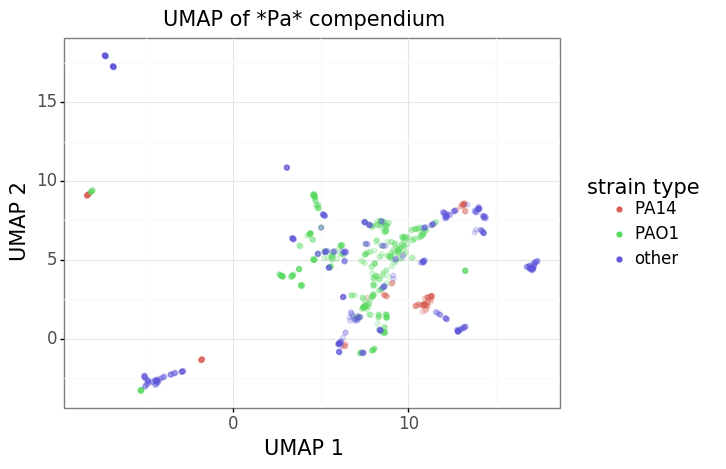

<ggplot: (8740093264255)>


In [13]:
# Plot
fig = ggplot(input_data_UMAPencoded_df, aes(x="1", y="2"))
fig += geom_point(aes(color="strain type"), alpha=0.2)
fig += labs(x="UMAP 1", y="UMAP 2", title="UMAP of *Pa* compendium")
fig += theme_bw()
fig += theme(
    legend_title_align="center",
    plot_background=element_rect(fill="white"),
    legend_key=element_rect(fill="white", colour="white"),
    legend_title=element_text(family="sans-serif", size=15),
    legend_text=element_text(family="sans-serif", size=12),
    plot_title=element_text(family="sans-serif", size=15),
    axis_text=element_text(family="sans-serif", size=12),
    axis_title=element_text(family="sans-serif", size=15),
)
fig += guides(colour=guide_legend(override_aes={"alpha": 1}))
# fig += scale_color_manual(['#ff6666', '#add8e6'])

print(fig)

In [14]:
# Load model
vae_model_dir = "models/NN_2500_30/"

# Files
model_encoder_filename = glob.glob(os.path.join(vae_model_dir, "*_encoder_model.h5"))[0]

weights_encoder_filename = glob.glob(
    os.path.join(vae_model_dir, "*_encoder_weights.h5")
)[0]

model_decoder_filename = glob.glob(os.path.join(vae_model_dir, "*_decoder_model.h5"))[0]

weights_decoder_filename = glob.glob(
    os.path.join(vae_model_dir, "*_decoder_weights.h5")
)[0]

# Load saved models
loaded_model = load_model(model_encoder_filename)
loaded_decode_model = load_model(model_decoder_filename)

loaded_model.load_weights(weights_encoder_filename)
loaded_decode_model.load_weights(weights_decoder_filename)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [15]:
# Encode normalized expression data
data_encoded = loaded_model.predict_on_batch(raw_pa_compendium_numeric)
data_encoded_df = pd.DataFrame(data_encoded, index=raw_pa_compendium_numeric.index)

In [16]:
# UMAP embedding of original input data

# pca = PCA(n_components=2)
# model = pca.fit(data_encoded_df)
# Get and save model
model = umap.UMAP(random_state=random_state).fit(data_encoded_df)

input_data_UMAPencoded = model.transform(data_encoded_df)
input_data_UMAPencoded_df = pd.DataFrame(
    data=input_data_UMAPencoded, index=data_encoded_df.index, columns=["1", "2"]
)
# Add label
input_data_UMAPencoded_df["strain type"] = raw_pa_compendium["strain type"]

input_data_UMAPencoded_df.head()

,1,2,strain type
05_PA14000-4-2_5-10-07_S2.CEL,10.532728,5.270761,PA14
54375-4-05.CEL,13.699041,10.695421,PAO1
AKGlu_plus_nt_7-8-09_s1.CEL,10.475706,5.227653,PA14
anaerobic_NO3_1.CEL,8.383018,7.848547,PA14
anaerobic_NO3_2.CEL,8.372976,7.824038,PA14


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


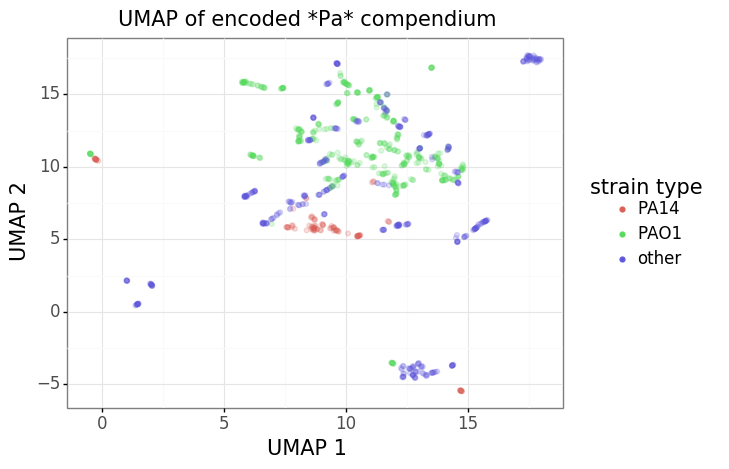

<ggplot: (8740091184588)>


In [17]:
# Plot
fig = ggplot(input_data_UMAPencoded_df, aes(x="1", y="2"))
fig += geom_point(aes(color="strain type"), alpha=0.2)
fig += labs(x="UMAP 1", y="UMAP 2", title="UMAP of encoded *Pa* compendium")
fig += theme_bw()
fig += theme(
    legend_title_align="center",
    plot_background=element_rect(fill="white"),
    legend_key=element_rect(fill="white", colour="white"),
    legend_title=element_text(family="sans-serif", size=15),
    legend_text=element_text(family="sans-serif", size=12),
    plot_title=element_text(family="sans-serif", size=15),
    axis_text=element_text(family="sans-serif", size=12),
    axis_title=element_text(family="sans-serif", size=15),
)
fig += guides(colour=guide_legend(override_aes={"alpha": 1}))
# fig += scale_color_manual(['#ff6666', '#add8e6'])

print(fig)